### Load Libraries

In [1]:
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np

### Load dataset

In [4]:
from keras.datasets import cifar10

### Set a variable learning rate

In [2]:
def lr_scheduler(epoch):
    lrate = .001
    if epoch > 75:
        lrate = .0005
    if epoch > 100:
        lrate = .0003
    return lrate

In [5]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")

### Z-score normalization of the training data

In [6]:
mean = np.mean(x_train, axis = (0,1,2,3))
std = np.std(x_train, axis = (0,1,2,3))
x_train = (x_train - mean)/ (std + 1e-7)
x_test = (x_test - mean)/ (std + 1e-7)

### OneHot encoding (Setting values of (y) to between 0 and 1)

In [7]:
num_classes = 10
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

### Building the model

In [9]:
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding = 'same', kernel_regularizer=regularizers.l2(weight_decay), 
                 input_shape = x_train.shape[1:]))
model.add(Activation('elu'))   # 'elu' stands for exponential linear unit
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding = 'same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(.2))

model.add(Conv2D(64, (3,3), padding = 'same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding = 'same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(.3))

model.add(Conv2D(128, (3,3), padding = 'same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding = 'same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(.4))

model.add(Flatten())  # Flatten the output to a list for comparison to the actual image
model.add(Dense(num_classes, activation = "softmax")) # This is the fully connected layer

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                        

### Data augmentation(transform the images a little bit so we can have more data to work with)

In [10]:
datagen = ImageDataGenerator(
rotation_range = 15,  # Rotate a bit
width_shift_range = .1,  # Widen a bit
height_shift_range = .1,  # Make a little bigger
horizontal_flip = True)  # Flip the image around

datagen.fit(x_train)

### Training the data

In [15]:
import tensorflow as tf

In [17]:
batch_size = 64
opt_rms = tf.keras.optimizers.RMSprop(lr = .0003, decay = 1e-6)
model.compile(loss = "categorical_crossentropy", optimizer = opt_rms,
             metrics = ["accuracy"])
model.fit_generator(datagen.flow(x_train, y_train, batch_size = batch_size),
                   steps_per_epoch = x_train.shape[0]//batch_size, epochs = 30,
                   verbose = 1, validation_data=(x_test, y_test))

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_3460/1210797900.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(datagen.flow(x_train, y_train, batch_size = batch_size),


Epoch 1/30
781/781 [==============================] - 664s 847ms/step - loss: 1.9490 - accuracy: 0.3939 - val_loss: 1.7583 - val_accuracy: 0.4715
Epoch 2/30
781/781 [==============================] - 611s 782ms/step - loss: 1.4299 - accuracy: 0.5239 - val_loss: 1.1643 - val_accuracy: 0.6262
Epoch 3/30
781/781 [==============================] - 638s 817ms/step - loss: 1.2001 - accuracy: 0.5979 - val_loss: 1.2397 - val_accuracy: 0.6238
Epoch 4/30
781/781 [==============================] - 677s 867ms/step - loss: 1.0770 - accuracy: 0.6403 - val_loss: 1.0223 - val_accuracy: 0.6795
Epoch 5/30
781/781 [==============================] - 658s 843ms/step - loss: 0.9961 - accuracy: 0.6700 - val_loss: 1.2359 - val_accuracy: 0.6465
Epoch 6/30
781/781 [==============================] - 666s 852ms/step - loss: 0.9248 - accuracy: 0.6934 - val_loss: 0.8927 - val_accuracy: 0.7275
Epoch 7/30
781/781 [==============================] - 640s 820ms/step - loss: 0.8874 - accuracy: 0.7095 - val_loss: 0.8675 -

### Saving the model to compare against the validation(test) set

In [18]:
model_json = model.to_json()

with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")

### Testing 

In [19]:
scores = model.evaluate(x_test, y_test, batch_size = 128, verbose = 1)
print('\nTest Results: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

79/79 [==============================] - 32s 405ms/step - loss: 0.5376 - accuracy: 0.8438

Test Results: 84.380 loss: 0.538


### Define a function to show the data

In [21]:
from matplotlib import pyplot
# from scipy.misc import toimage
# from scipy.misc import imshow
from matplotlib.pyplot import imshow
from keras.datasets import cifar10
def show_images(X):
    pyplot.figure(1)
    k = 0
    for i in range(0,4):
        for j in range(0,4):
            pyplot.subplot2grid((4,4),(i,j))
            pyplot.imshow((X[k]))
            k = k + 1
    # Show the plot
    pyplot.show()    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

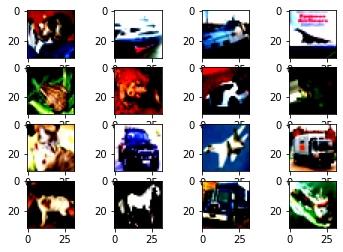

['frog', 'automobile', 'ship', 'airplane', 'frog', 'frog', 'automobile', 'frog', 'cat', 'automobile', 'airplane', 'truck', 'dog', 'horse', 'truck', 'ship']


In [24]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype("float32")
x_test = x_test.astype("float32")

# Normalization

mean = np.mean(x_train, axis = (0,1,2,3))
std = np.std(x_train, axis = (0,1,2,3))
x_train = (x_train - mean)/ (std + 1e-7)
x_test = (x_test - mean)/ (std + 1e-7)

show_images(x_test[:16])  # Shows the related images from the test set

# Loading trained CNN model
json_file = open("model.json", "r")
loaded_model_json = json_file.read()
json_file.close()
from keras.models import model_from_json
model = model_from_json(loaded_model_json)
model.load_weights("model.h5")

labels = ["airplane", "automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

indices = np.argmax(model.predict(x_test[:16]), 1)
print([labels[x] for x in indices]) # prints the labels from highest to lowest count order for the test rows
# (or) for x in indices:
        #  print(labels[x])

In [25]:
y_test[0]

array([3], dtype=uint8)

In [27]:
model.predict(x_test[:16])

array([[8.87580798e-04, 3.57977487e-02, 5.87181002e-03, 3.49847227e-01,
        3.95758310e-03, 3.28527726e-02, 5.58015049e-01, 7.53102286e-05,
        1.23483967e-02, 3.46594228e-04],
       [3.75622130e-06, 8.26516211e-01, 1.25653898e-09, 9.62316338e-10,
        1.45453274e-10, 2.39875845e-11, 6.57646049e-10, 1.01387149e-10,
        1.73464447e-01, 1.56358838e-05],
       [1.84653467e-03, 4.09492344e-01, 7.98903202e-05, 1.14073164e-05,
        1.00774678e-05, 1.80773509e-06, 1.18468612e-04, 2.03639866e-06,
        5.87853134e-01, 5.84267429e-04],
       [9.72975671e-01, 7.29949959e-03, 1.98630639e-03, 7.19816599e-04,
        5.27479551e-06, 2.37885183e-06, 1.04627670e-05, 3.69851978e-06,
        1.64203029e-02, 5.76609396e-04],
       [3.62574362e-08, 4.88893013e-04, 1.68244704e-03, 7.16764116e-05,
        1.12315283e-04, 3.00367077e-07, 9.97640014e-01, 1.64925709e-07,
        2.76074456e-06, 1.39758083e-06],
       [6.22499874e-09, 2.30728947e-08, 9.84629060e-06, 4.07093699e-04,
   